In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from BehaviourDatasets import TSDataset
import joblib
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from sklearn.preprocessing import RobustScaler,StandardScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score,matthews_corrcoef,confusion_matrix
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Hyperparameters

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
sequence_length = 50
n_channels= 9
hidden_size = 128
batch_size =128
num_layers = 2
num_classes = 2
n_filters=256
filter_size=5

# Data Loading

In [0]:
scaler=RobustScaler()
encoder=LabelEncoder()
folder="/gdrive/My Drive/HAR_Dataset"
#creating train and valid datasets
train_dataset= TSDataset(folder,scaler,"Train",encoder,n_channels)
validation_dataset= TSDataset(folder,scaler,"Val",encoder,n_channels)

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=batch_size,shuffle=True)
data_loaders=[train_loader,val_loader]

# Model Init

In [0]:
from TSResNet import tsresnet_shallow
from pytorchtools import prepare_batch_tsresnet
#Init Model
num_classes=len(train_dataset.classes)
model = tsresnet_shallow(**{"num_classes":num_classes}).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()


# Training

In [0]:
from pytorchtools import EarlyStopping
from Training import Trainer
exp_path="/content/run/ResNet_capada"
early_stopping=EarlyStopping(patience=1500)
opt_parameters={
    "lr":0.01,
    #optionals...
    "weight_decay":0.00001             
}
      
n_epochs=100
metrics_dict={ "Accuracy":balanced_accuracy_score,
              "f1":[f1_score,{"average":'weighted'}],
              "Mcc":matthews_corrcoef
              }

trainer=Trainer(model,criterion,opt_parameters,data_loaders,prepare_batch_tsresnet)
_=trainer.train(n_epochs,exp_path,metrics_dict,early_stopping)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Train resultsloss = 1.5519841146469116 ,Accuracy = 0.42272191915684104 ,f1 = 0.6546068074764516 ,Mcc = 0.045123997402294995 
Test resultsloss = 29.616650122914994 ,Accuracy = 0.49439427393498564 ,f1 = 0.7270330293470054 ,Mcc = 0.05166894847714099 
----------
Train resultsloss = 1.4050964736938476 ,Accuracy = 0.48599068301496184 ,f1 = 0.669913060211908 ,Mcc = 0.11427336724509826 
Test resultsloss = 1.6299302755083358 ,Accuracy = 0.5532489017521316 ,f1 = 0.7735576184550425 ,Mcc = 0.08876140754838772 
----------
Train resultsloss = 1.3485627126693727 ,Accuracy = 0.510379736883188 ,f1 = 0.6650782738529414 ,Mcc = 0.16111411202062034 
Test resultsloss = 1.5992384685788839 ,Accuracy = 0.5588801016072203 ,f1 = 0.7525412308998584 ,Mcc = 0.12977023943352797 
----------
Train resultsloss = 1.3444127821922303 ,Accuracy = 0.5285653821063631 ,f1 = 0.6695605787064306 ,Mcc = 0.164426410925421 
Test resultsloss = 1.5940770673751827 ,Accuracy = 0.5948101941632893 ,f1 = 0.7654307584669402 ,Mcc = 0.137411

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8c911cc07d38>", line 18, in <module>
    _=trainer.train(n_epochs,exp_path,metrics_dict,early_stopping)
  File "/content/Training.py", line 138, in train
    metrics_dict)
  File "/content/Training.py", line 88, in evaluate_set
    self._get_metrics(labels_pred,labels,actual_metrics,metrics_dict)
  File "/content/Training.py", line 70, in _get_metrics
    labels_pred,labels=self._prob_to_predictions(preds,labels)
  File "/content/Training.py", line 59, in _prob_to_predictions
    probabilities=F.softmax(preds,dim=1)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py", line 1231, in softmax
    ret = input.softmax(dim)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/

KeyboardInterrupt: ignored

# Load trained model

In [0]:
checkpoint_path=os.path.join(exp_path,"checkpoint.pth")
model = tsresnet_shallow(**{"num_classes":num_classes})

model.load_state_dict(torch.load(checkpoint_path))
model=model.to(device)


# Evaluate trained model

In [0]:
from Evaluation import Evaluator
evaluator_val=Evaluator(model,criterion,validation_dataset,val_loader,prepare_batch_tsresnet) #val set
evaluator_train=Evaluator(model,criterion,train_dataset,train_loader,prepare_batch_tsresnet) #val set


Normalized confusion matrix


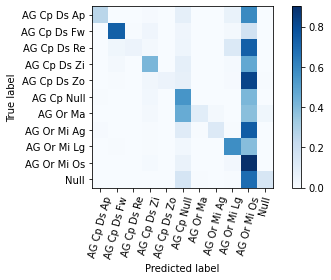

In [0]:
evaluator_train.plt_conf_matrix(normalize=True)

Normalized confusion matrix


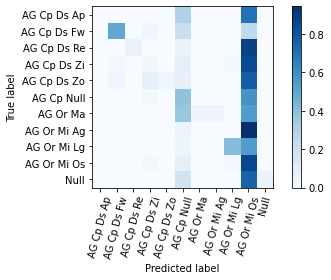

In [0]:
evaluator_val.plt_conf_matrix(normalize=True)

# Tensorboard

In [0]:
%tensorboard --logdir=run

In [0]:
!rm -r /content/run/dp_0.5_hs_30_v2/*


In [0]:
!zip -r runs_ResNet_first.zip run
